# Problem Statement:
In today’s world, data is power. With News companies having terabytes of data stored in
servers, everyone is in the quest to discover insights that add value to the organization.
With various examples to quote in which analytics is being used to drive actions, one that
stands out is news article classification.
Nowadays on the Internet there are a lot of sources that generate immense amounts of
daily news. In addition, the demand for information by users has been growing
continuously, so it is crucial that the news is classified to allow users to access the
information of interest quickly and effectively. This way, the machine learning model for
automated news classification could be used to identify topics of untracked news and/or
make individual suggestions based on the user’s prior interests.

## EDA

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
import gensim
import wordcloud
import textblob
import spacy
import textstat
import pyLDAvis

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop = stopwords.words('english')

/config/workspace/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to /config/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /config/nltk_data...
[nltk_data] Downloading package punkt to /config/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df = pd.read_csv("/config/workspace/source/train/train.csv")
df.columns = [column.lower() for column in df.columns]
df.head()

,articleid,text,category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   articleid  1490 non-null   int64 
 1   text       1490 non-null   object
 2   category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
def null_count(df):
    return df.isna().sum()

null_count(df)

articleid    0
text         0
category     0
dtype: int64

### Count the Stop Words

In [5]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text', 'stopwords']]


,text,stopwords
0,worldcom ex-boss launches defence lawyers defe...,108
1,german business confidence slides german busin...,120
2,bbc poll indicates economic gloom citizens in ...,220
3,lifestyle governs mobile choice faster bett...,276
4,enron bosses in $168m payout eighteen former e...,142
...,...,...
1485,double eviction from big brother model caprice...,97
1486,dj double act revamp chart show dj duo jk and ...,237
1487,weak dollar hits reuters revenues at media gro...,87
1488,apple ipod family expands market apple has exp...,230


### Number of Punctuations

In [6]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

df['punctuations'] = df['text'].apply(lambda x: count_punct(x))

In [7]:
df[['text','punctuations']]

,text,punctuations
0,worldcom ex-boss launches defence lawyers defe...,22
1,german business confidence slides german busin...,25
2,bbc poll indicates economic gloom citizens in ...,36
3,lifestyle governs mobile choice faster bett...,42
4,enron bosses in $168m payout eighteen former e...,31
...,...,...
1485,double eviction from big brother model caprice...,22
1486,dj double act revamp chart show dj duo jk and ...,35
1487,weak dollar hits reuters revenues at media gro...,24
1488,apple ipod family expands market apple has exp...,33


### Number of Numerics

In [8]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']]

,text,numerics
0,worldcom ex-boss launches defence lawyers defe...,4
1,german business confidence slides german busin...,2
2,bbc poll indicates economic gloom citizens in ...,17
3,lifestyle governs mobile choice faster bett...,4
4,enron bosses in $168m payout eighteen former e...,3
...,...,...
1485,double eviction from big brother model caprice...,2
1486,dj double act revamp chart show dj duo jk and ...,7
1487,weak dollar hits reuters revenues at media gro...,7
1488,apple ipod family expands market apple has exp...,9


### Number of Upper Case Words

In [9]:
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text', 'upper']]

,text,upper
0,worldcom ex-boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens in ...,0
3,lifestyle governs mobile choice faster bett...,0
4,enron bosses in $168m payout eighteen former e...,0
...,...,...
1485,double eviction from big brother model caprice...,0
1486,dj double act revamp chart show dj duo jk and ...,0
1487,weak dollar hits reuters revenues at media gro...,0
1488,apple ipod family expands market apple has exp...,0


## Data Cleaning

### Text to Lower Case

In [10]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle governs mobile choice faster better ...
4    enron bosses in $168m payout eighteen former e...
Name: text, dtype: object

### Removing Punctuations

In [11]:
df['text'] = df['text'].str.replace("[^\w\s]","")
df['text'].head()

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
/tmp/ipykernel_803/4045176609.py:1: DeprecationWarning: invalid escape sequence \w
  df['text'] = df['text'].str.replace("[^\w\s]","")


0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle governs mobile choice faster better ...
4    enron bosses in 168m payout eighteen former en...
Name: text, dtype: object

### Removing Stop Words

In [12]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Remove URLs

In [13]:
import re
def remove_url(text):
    return re.sub(r'\S*https?:\S*','', text)

In [14]:
df['text'] = df['text'].apply(lambda x: remove_url(x))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Remove HTML Tags

In [15]:
def remove_html(text):
    return re.sub(r"<.*?>","", text)

In [16]:
df['text'] = df['text'].apply(lambda x: remove_html(x))
df['text']

0       worldcom exboss launches defence lawyers defen...
1       german business confidence slides german busin...
2       bbc poll indicates economic gloom citizens maj...
3       lifestyle governs mobile choice faster better ...
4       enron bosses 168m payout eighteen former enron...
                              ...                        
1485    double eviction big brother model caprice holb...
1486    dj double act revamp chart show dj duo jk joel...
1487    weak dollar hits reuters revenues media group ...
1488    apple ipod family expands market apple expande...
1489    santy worm makes unwelcome visit thousands web...
Name: text, Length: 1490, dtype: object

### Remove Emoji's

In [17]:
def remove_emoji(text):
    return re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', text)

In [18]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))
df['text'].head()

0    worldcom exboss launches defence lawyers defen...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens maj...
3    lifestyle governs mobile choice faster better ...
4    enron bosses 168m payout eighteen former enron...
Name: text, dtype: object

### Spell Correction

In [19]:
# from textblob import TextBlob
# df['text'].apply(lambda x: str(TextBlob(x).correct()))

###

### Lemmatization with pos

In [34]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def get_wordnet_pos(word):
    treebank_tag = nltk.pos_tag([word])[0][1]

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()
   
def lemma_clean_text(text, cores=1):
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    return sample


In [35]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(b) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [ ]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# Define a function to convert part of speech tags to WordNet part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# Define a sample sentence
sentence = "The quick brown fox jumps over the lazy dog."

# Tokenize and tag the sentence
tagged_tokens = pos_tag(sentence.split())

# Iterate over the tagged tokens and lemmatize each token
lemmatized_tokens = [(lemmatizer.lemmatize(token[0], pos=get_wordnet_pos(token[1])), token[1]) for token in tagged_tokens[:-1]]

# Print the original tokens, the lemmatized tokens, the part of speech tags, and the WordNet part of speech
for token in tagged_tokens[:-1]:
    print(f"Original token: {token[0]}")
    print(f"Lemmatized token: {lemmatizer.lemmatize(token[0], pos=get_wordnet_pos(token[1]))}")
    print(f"Part of speech tag: {token[1]}")
    print(f"WordNet part of speech: {get_wordnet_pos(token[1])}")
    print()


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

def preprocess(text):
  # Tokenize the text
  tokens = nltk.word_tokenize(text)
  
  # Add part-of-speech tags
  tagged_tokens = nltk.pos_tag(tokens)
  
  # Lemmatize the tokens
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [(lemmatizer.lemmatize(token[0], pos=get_wordnet_pos(token[1])), token[1]) for token in tagged_tokens]
  
  return lemmatized_tokens

def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

text = "This is a sample sentence with some lemmatization."
lemmatized_tokens = preprocess(text)
print(lemmatized_tokens)


In [36]:
df['text'] = df['text'].apply(lambda x: correct_text(x, lemma=True))

In [38]:
df

,articleid,text,category,stopwords,punctuations,numerics,upper
0,1833,worldcom exboss launches defence lawyers defen...,business,108,22,4,0
1,154,german business confidence slides german busin...,business,120,25,2,0
2,1101,bbc poll indicates economic gloom citizens maj...,business,220,36,17,0
3,1976,lifestyle governs mobile choice faster better ...,tech,276,42,4,0
4,917,enron bosses 168m payout eighteen former enron...,business,142,31,3,0
...,...,...,...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,97,22,2,0
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,237,35,7,0
1487,1590,weak dollar hits reuters revenues media group ...,business,87,24,7,0
1488,1587,apple ipod family expands market apple expande...,tech,230,33,9,0


<AxesSubplot: >

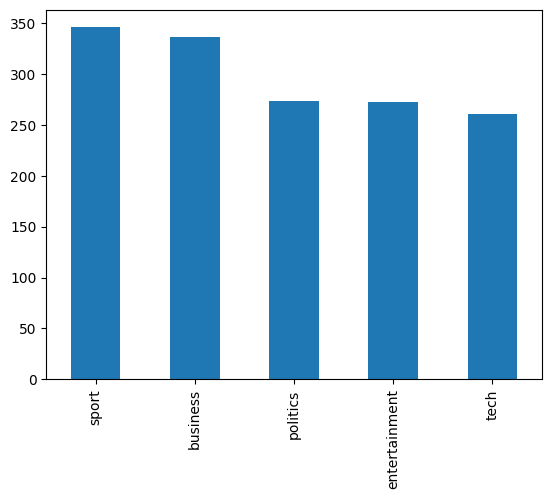

In [ ]:
df['category'].value_counts().plot(kind='bar')

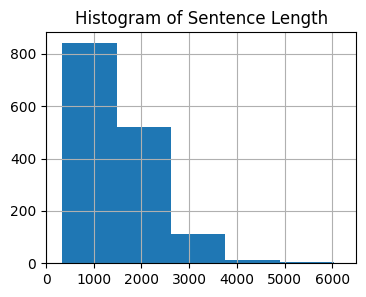

In [ ]:
plt.figure(figsize=(4,3))
df['text'].str.len().hist()
plt.xlim([0,6500])
plt.title("Histogram of Sentence Length")
plt.show()

In [ ]:
df['text'].str.split().map(lambda x: len(x))

0       191
1       203
2       292
3       353
4       211
       ... 
1485    124
1486    314
1487    148
1488    327
1489    173
Name: text, Length: 1490, dtype: int64

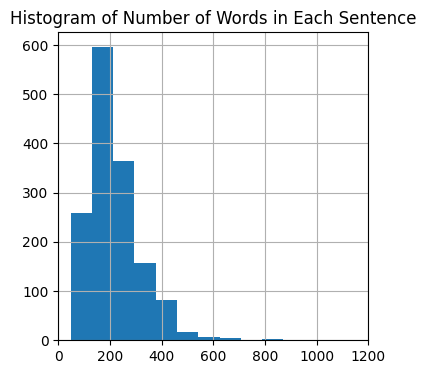

In [ ]:
plt.figure(figsize=(4,4))
plt.title("Histogram of Number of Words in Each Sentence")
df['text'].str.split().map(lambda x: len(x)).hist(bins=20)
plt.xlim([0,1200])
plt.show()

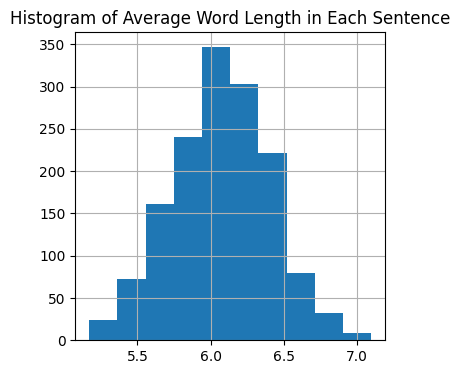

In [ ]:
plt.figure(figsize=(4,4))
df['text'].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title("Histogram of Average Word Length in Each Sentence")
plt.show()

From the Above figure we can conclude below
* Each Sentence length in a news article is ranging from 500 to 6000
* The number of words in each sentence is ranging from 100 to 1100
* Average Word length in each sentence is ranging from 3.5 to 5.5

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

def prior_eda(df, column):
    df['stopwords'] = df[column].apply(lambda x: len([x for x in x.split() if x in stop]))
    df['punctuations'] = df[column].apply(lambda x: count_punct(x))
    df['numerics'] = df[column].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
    df['upper'] = df[column].apply(lambda x: len([x for x in x.split() if x.isupper()]))
    return df    

In [ ]:
import re 
from textblob import TextBlob

def remove_url(text):
    return re.sub(r'\S*https?:\S*','', text)

def remove_html(text):
    return re.sub(r"<.*?>","", text)

def remove_emoji(text):
    return re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', text)

In [ ]:
def clean_text(text):
    

LookupError: 
**********************************************************************
  Resource [93mwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('words')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/words[0m

  Searched in:
    - '/config/nltk_data'
    - '/config/workspace/venv/nltk_data'
    - '/config/workspace/venv/share/nltk_data'
    - '/config/workspace/venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
data['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))
data.head()

NameError: name 'only_english' is not defined

In [ ]:
def get_wordnet_pos(word):
    treebank_tag = nltk.pos_tag([word])[0][1]
    

In [ ]:
def posterior_eda(df, column):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.suptitle("Sentence, Word, Average Word Lengths")
    ax1.hist(df[column].str.len())
    ax2.hist(df[column].str.split().map(lambda x: len(x)))
    ax3.hist(df[column].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)))
    plt.show()